In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking, LSTM, Dense, TimeDistributed

import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from hmmlearn import hmm
from collections import defaultdict

rc('font', family='Malgun Gothic')  

In [2]:
# 난수 시드 고정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
# --------------------------------------------------------------------------------
# 1) 데이터 로드 & 전처리 _datawizardd
# --------------------------------------------------------------------------------

data_dir = "hand_data"
files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

all_sequences = []
all_labels = []
max_len = 0

for file_name in files:
    csv_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(csv_path, encoding="cp949")
    df.sort_values(by='Time', inplace=True)

    # CSV 하나당 하나의 Gesture만 기록
    gesture_name = df['Gesture'].iloc[0]

    # Time별로 (ID=0~20) 좌표를 모아 (T, 63) 구성
    frames = []
    unique_times = df['Time'].unique()
    for t in unique_times:
        df_t = df[df['Time'] == t]
        row_data = []
        for landmark_id in range(21):
            sub = df_t[df_t['ID'] == landmark_id]
            if len(sub) == 0:
                row_data.extend([0.0, 0.0, 0.0])
            else:
                x_val = sub['X'].values[0]
                y_val = sub['Y'].values[0]
                z_val = sub['Z'].values[0]
                row_data.extend([x_val, y_val, z_val])
        frames.append(row_data)

    seq = np.array(frames)  # shape=(T, 63)
    if seq.shape[0] > max_len:
        max_len = seq.shape[0]

    all_sequences.append(seq)
    all_labels.append(gesture_name)

# 0-padding (뒤쪽)
padded_sequences = []
for seq in all_sequences:
    T_current = seq.shape[0]
    if T_current < max_len:
        pad_width = ((0, max_len - T_current), (0, 0))
        seq_padded = np.pad(seq, pad_width, mode='constant', constant_values=0.0)
    else:
        seq_padded = seq[:max_len]
    padded_sequences.append(seq_padded)

X = np.array(padded_sequences)  
y = np.array(all_labels)        

print("X.shape:", X.shape)  
print("y.shape:", y.shape)
print("Unique gestures:", np.unique(y))

X.shape: (1800, 135, 63)
y.shape: (1800,)
Unique gestures: ['감기(기침)' '결핵' '고혈압' '변비' '병' '선생님' '소변' '소화' '수술' '아프다' '약' '열나다' '잠'
 '저혈압' '주사' '처음' '추워요' '콧물감기']


In [4]:
# --------------------------------------------------------------------------------
# 2) Train/Test 분할 _datawizardd
# --------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (1440, 135, 63) (1440,)
Test set: (360, 135, 63) (360,)


In [5]:
# --------------------------------------------------------------------------------
# 3) 스케일링(정규화) _datawizardd
# --------------------------------------------------------------------------------

N_train, T, D = X_train.shape
N_test = X_test.shape[0]

# StandardScaler는 2D 데이터에 대해 작동하므로 reshape
X_train_reshaped = X_train.reshape(N_train*T, D)
X_test_reshaped = X_test.reshape(N_test*T, D)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# 다시 3D로 복원
X_train_scaled = X_train_scaled.reshape(N_train, T, D)
X_test_scaled = X_test_scaled.reshape(N_test, T, D)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 135, 63)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 135, 63)           │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 135, 63)           │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 135)               │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 135, 64)           │          32,768 │ masking[0][0], any[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 135, 32)           │          12,416 │ lstm[0][0], any[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 135, 32)           │           8,320 │ lstm_1[0][0], any[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 135, 64)           │          24,832 │ lstm_2[0][0], any[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 135, 63)           │           4,095 │ lstm_3[0][0], any[0][0]    │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,431 (322.00 KB)

 Trainable params: 82,431 (322.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 0.9194 - val_loss: 0.6288
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.5629 - val_loss: 0.3696
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.3649 - val_loss: 0.2971
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.3012 - val_loss: 0.2574
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.2642 - val_loss: 0.2300
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.2384 - val_loss: 0.2042
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.2138 - val_loss: 0.1844
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.1901 - val_loss: 0.1669
Epoch 9/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.1730 - val_loss: 0.1513
Epoch 10/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.1584 - val_loss: 0.1385


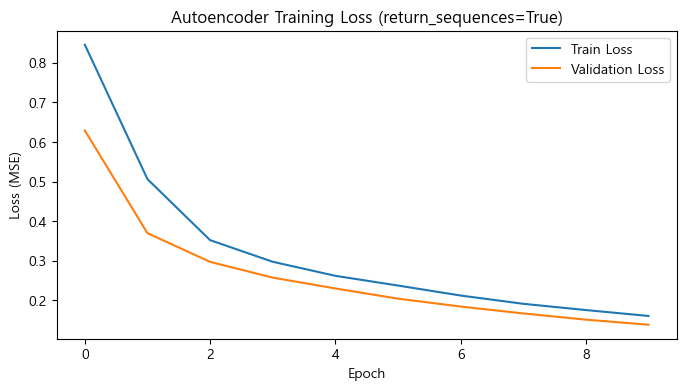

In [6]:
# --------------------------------------------------------------------------------
# 4) LSTM 오토인코더 (시점별 Latent 추출) _datawizardd
# --------------------------------------------------------------------------------
# 목표: 입력 (N, T, D) -> 인코더 -> (N, T, latent_dim)
#       디코더 -> (N, T, D)
# 여기서는 encoder 마지막 LSTM에서 return_sequences=True로
# "각 타임스텝마다 latent_dim"을 출력하게 함

latent_dim = 32

input_layer = keras.Input(shape=(T, D))

# 패딩된 0 구간 무시
x = Masking(mask_value=0.0)(input_layer)

# 인코더: return_sequences=True로 설정
x = LSTM(64, return_sequences=True, dropout=0.2)(x)
encoded = LSTM(latent_dim, return_sequences=True, dropout=0.2)(x)
# => encoded.shape = (N, T, latent_dim)

# 디코더 (encoded -> 재구성)
# 여기서는 return_sequences=True
x = LSTM(latent_dim, return_sequences=True, dropout=0.2)(encoded)
x = LSTM(64, return_sequences=True, dropout=0.2)(x)
decoded = TimeDistributed(Dense(D))(x)
# => decoded.shape = (N, T, D)

autoencoder = keras.Model(input_layer, decoded)

# 인코더 전용 모델(입력 -> encoded) 빼 두기
encoder = keras.Model(input_layer, encoded)

# 옵티마이저
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=10,
    batch_size=8,
    validation_split=0.2,
    shuffle=True
)

# 학습 곡선
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss (return_sequences=True)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [7]:
# --------------------------------------------------------------------------------
# 5) 오토인코더 인코더 부분으로 시점별 Latent 시퀀스 추출 _datawizardd
# --------------------------------------------------------------------------------

latent_train = encoder.predict(X_train_scaled) 
latent_test  = encoder.predict(X_test_scaled)  

print("latent_train.shape:", latent_train.shape)  
print("latent_test.shape :", latent_test.shape)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
latent_train.shape: (1440, 135, 32)
latent_test.shape : (360, 135, 32)


In [8]:
# --------------------------------------------------------------------------------
# 6) HMM 학습 _datawizardd
# --------------------------------------------------------------------------------
# 시퀀스 단위로: 한 샘플 -> (T, latent_dim)
# Gesture별로 묶어서 HMM 훈련
# hmmlearn: fit(X_concat, lengths) 형태 사용
# - X_concat = 모든 시퀀스를 세로로 이어붙인 것 (sum of T_i, latent_dim)
# - lengths = 각 시퀀스 길이 목록 [T_1, T_2, ..., T_n]

gesture_dict_train = defaultdict(list)
for lat_seq, label in zip(latent_train, y_train):
    # lat_seq.shape = (T, latent_dim)
    gesture_dict_train[label].append(lat_seq)

gesture_models = {}
n_components = 5  # 숨겨진 상태 수(하이퍼파라미터)

for gesture_name, seq_list in gesture_dict_train.items():
    # seq_list = [ (T1, latent_dim), (T2, latent_dim), ... ]
    # concat
    X_concat = np.concatenate(seq_list, axis=0)  # shape=(sum(T_i), latent_dim)
    lengths = [s.shape[0] for s in seq_list]

    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type='diag',
        n_iter=100,
        random_state=42
    )
    model.fit(X_concat, lengths)
    gesture_models[gesture_name] = model



In [9]:
# --------------------------------------------------------------------------------
# 7) 테스트(분류) - HMM log-likelihood 비교 _datawizardd
# --------------------------------------------------------------------------------
def classify_hmm(sequence_2d):
    """
    sequence_2d: shape=(T, latent_dim)
    return: (best_label, best_score)
    """
    best_label = None
    best_score = -np.inf
    length = [sequence_2d.shape[0]]  # 단일 시퀀스 길이

    for gesture_name, model in gesture_models.items():
        score = model.score(sequence_2d, length)
        if score > best_score:
            best_score = score
            best_label = gesture_name

    return best_label, best_score

correct = 0
total = 0

for lat_seq, true_label in zip(latent_test, y_test):
    pred_label, pred_score = classify_hmm(lat_seq)
    if pred_label == true_label:
        correct += 1
    total += 1

acc = correct / total
print(f"HMM Test Accuracy: {acc:.4f}  ({correct}/{total})")

HMM Test Accuracy: 0.7944  (286/360)


In [10]:
# 예측 라벨 생성
y_pred = []
for lat_seq in latent_test:
    pred_label, _ = classify_hmm(lat_seq)  # classify_hmm 함수 사용
    y_pred.append(pred_label)

In [11]:
# classification_report 생성
report = classification_report(y_test, y_pred, digits=4, output_dict=True)

# Pandas 데이터프레임으로 변환
df_report = pd.DataFrame(report).transpose()

# 표 출력
df_report

,precision,recall,f1-score,support
감기(기침),1.000000,0.117647,0.210526,17.000000
결핵,1.000000,0.266667,0.421053,15.000000
고혈압,0.677419,1.000000,0.807692,21.000000
변비,1.000000,0.807692,0.893617,26.000000
병,0.840000,0.913043,0.875000,23.000000
선생님,0.685714,0.960000,0.800000,25.000000
소변,0.750000,1.000000,0.857143,18.000000
소화,1.000000,0.789474,0.882353,19.000000
수술,0.894737,0.944444,0.918919,18.000000
아프다,0.695652,0.888889,0.780488,18.000000


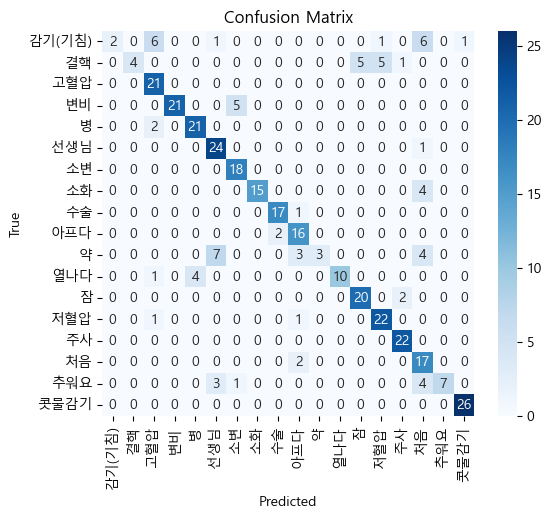

In [12]:
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

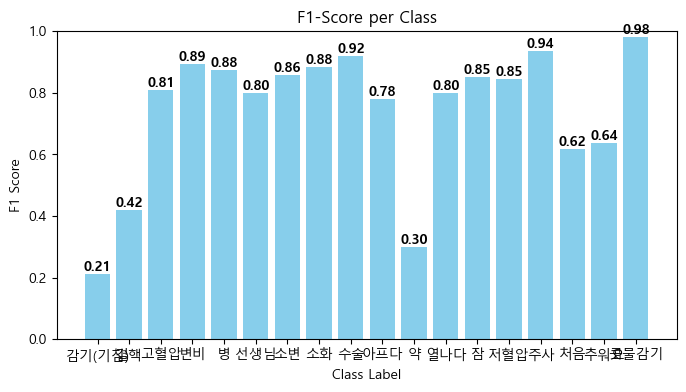

In [13]:
# 클래스별 F1 점수
f1_per_class = f1_score(y_test, y_pred, average=None, labels=labels)

plt.figure(figsize=(8, 4))
plt.bar(labels, f1_per_class, color='skyblue')
plt.title("F1-Score per Class")
plt.xlabel("Class Label")
plt.ylabel("F1 Score")
plt.ylim([0, 1])  # F1은 0~1 사이
for i, v in enumerate(f1_per_class):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()